# Goodness of Fitting Measure

After so many doubts on the validity of the fitting on our MSDs, I want to find a way to quantify the goodness of fitting to make unarbitrary judgement on method. Here, we simulate a test MSD data, try to fit with different methods and compare the goodness of fitting by a single number metric. 

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import trackpy as tp
from myImageLib import bestcolor

## 1 Simulate MSD data

Before creating simulated data, let's first try to get an approximate model from a real MSD. We use traj 109

In [207]:
folder = r"../data/traj"
n = 100
traj = pd.read_csv(os.path.join(folder, "{:02d}.csv".format(n))).fillna(method="ffill")

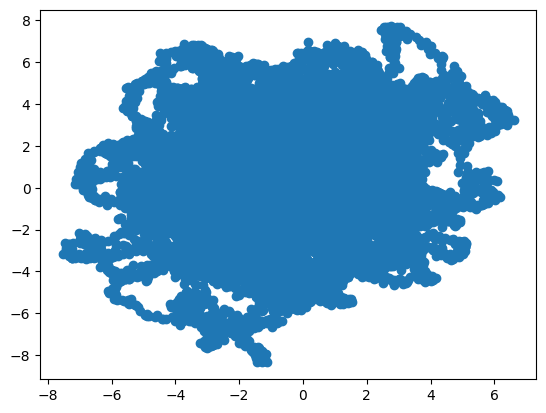

In [208]:
plt.scatter(traj.x, traj.y)

[]

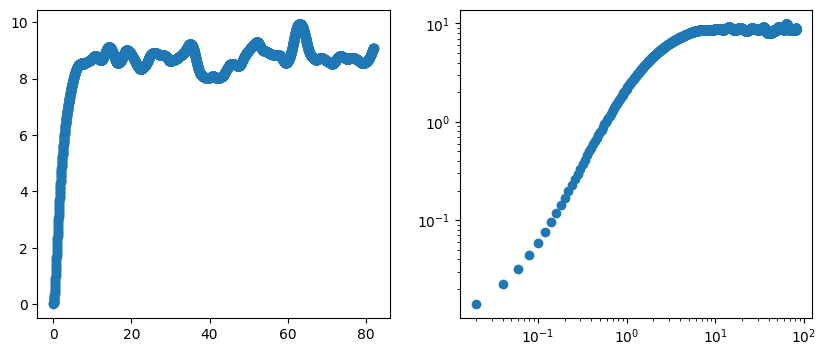

In [209]:
msd = tp.msd(traj, mpp=1, fps=50, max_lagtime=len(traj)//10)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(msd.lagt, msd["<y^2>"])
ax[1].scatter(msd.lagt, msd["<y^2>"])
ax[1].loglog()

0.08036164551005975


[]

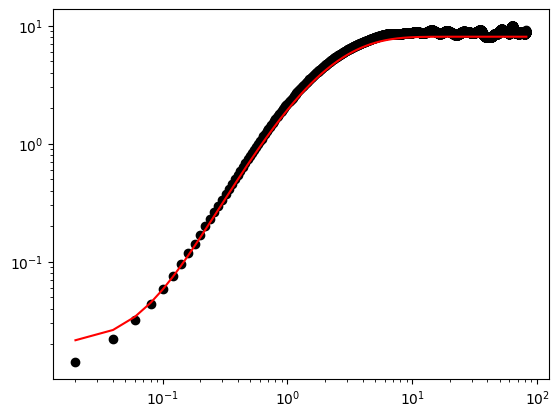

In [231]:
x = msd.lagt
y = msd["<y^2>"]
yfit = offset_reduced_memory_model(x, *(2.404, 0.47, 2.054, 0.02))
print(fit_error(y, yfit))
plt.scatter(x, y, marker="o", color="black")
plt.plot(x, yfit, color="red")
plt.loglog()

Try to fit with Maggi model with a constant offset:
$$
\left< \Delta y^2 \right> = 2 D_T\tau^* ( 1 - e^{-t/\tau^*}) + 2 D_A \tau^* \frac{ 1 - e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1 - (\tau/\tau^*)^2}
$$

The $\tau$ terms are responsible for the effect of noisy memory (color). It makes the long time displacement (saturation) longer.

### Memoryless model ($\tau=0$)

$$
\left< \Delta y^2 \right> = 2 (D_T+D_A)\tau^* ( 1 - e^{-t/\tau^*})
$$

In [13]:
def memoryless_model(x, D, tau_star):
    """tau=0 variation of Maggi model"""
    dy2 = 2 * D * tau_star * (1 - np.exp(-x/tau_star))
    return dy2

#### Fit original

In [192]:
x = msd.lagt
y = msd["<y^2>"]
popt, pcov = curve_fit(memoryless_model, x, y, p0=[1, 2])

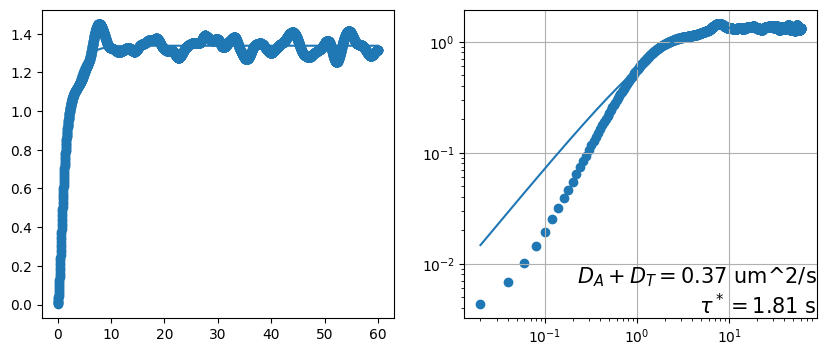

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(msd.lagt, msd["<y^2>"])
ax[0].plot(x, memoryless_model(x, *popt))
ax[1].scatter(msd.lagt, msd["<y^2>"])
ax[1].plot(x, memoryless_model(x, *popt))
ax[1].annotate("$D_A+D_T=${0:.2f} um^2/s\n$\\tau^*=${1:.2f} s".format(popt[0], popt[1]), 
               [1, 0], horizontalalignment="right", verticalalignment="bottom", xycoords="axes fraction",
               fontsize=15)
ax[1].loglog()
ax[1].grid()

#### Fit log

In [24]:
def memoryless_model_log(x, D, tau_star):
    """tau=0 variation of Maggi model"""
    dy2 = 2 * D * tau_star * (1 - np.exp(-x/tau_star))
    return np.log(dy2)

In [128]:
x = msd.lagt
y = msd["<y^2>"]
popt, pcov = curve_fit(memoryless_model_log, x, np.log(y), p0=[1, 2])

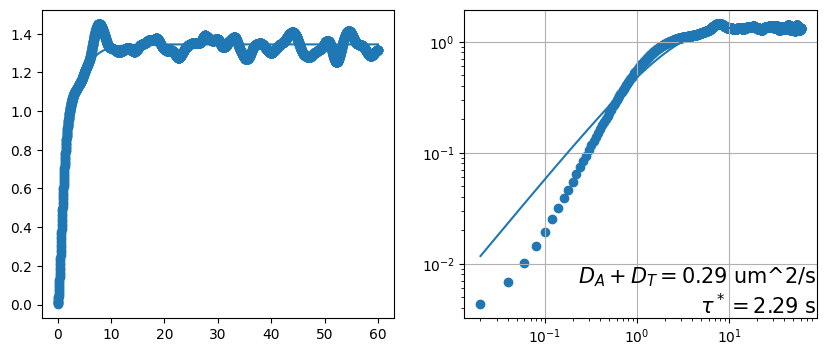

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(msd.lagt, msd["<y^2>"])
ax[0].plot(x, memoryless_model(x, *popt))
ax[1].scatter(msd.lagt, msd["<y^2>"])
ax[1].plot(x, memoryless_model(x, *popt))
ax[1].annotate("$D_A+D_T=${0:.2f} um^2/s\n$\\tau^*=${1:.2f} s".format(popt[0], popt[1]), 
               [1, 0], horizontalalignment="right", verticalalignment="bottom", xycoords="axes fraction",
               fontsize=15)
ax[1].loglog()
ax[1].grid()

By fitting the log model , we make the short time regime weigh more than the original fitting, so that the short time regime fitting gets closer to the data. But the transition time gets more inaccurate.

### Model with memory

#### Fit original

Try to fit with Maggi model with a constant offset:
$$
\left< \Delta y^2 \right> = 2 D_T\tau^* ( 1 - e^{-t/\tau^*}) + 2 D_A \tau^* \frac{ 1 - e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1 - (\tau/\tau^*)^2}
$$

In [28]:
def memory_model(x, DA, DT, tau, tau_star):
    dy2 = 2 * DT * tau_star * (1-np.exp(-x/tau_star)) + 2 * DA * tau_star * (1 - np.exp(-x/tau_star) - tau/tau_star*(1-np.exp(-x/tau))) / (1 - (tau/tau_star)**2)
    return dy2

In [124]:
x = msd.lagt
y = msd["<y^2>"]
popt, pcov = curve_fit(memory_model, x, y, p0=[1, .03, .1, 2])

In [125]:
popt

array([ 0.69413355, -0.26960691,  0.07072664,  1.68562856])

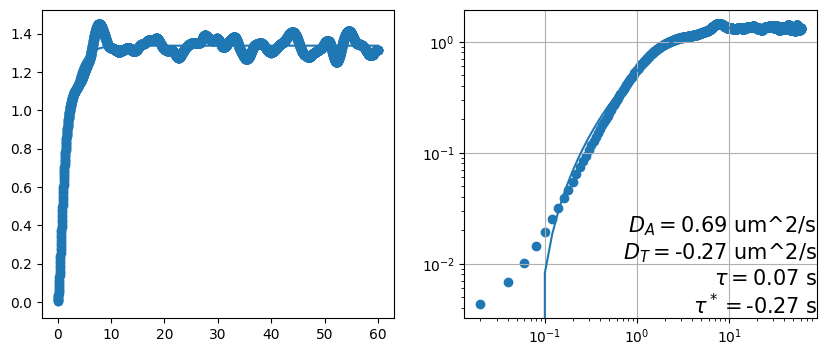

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(x, y)
ax[0].plot(x, memory_model(x, *popt))
ax[1].scatter(x, y)
ax[1].plot(x, memory_model(x, *popt))
ax[1].annotate("$D_A=${0:.2f} um^2/s\n$D_T=${1:.2f} um^2/s\n$\\tau=${2:.2f} s\n$\\tau^*=${1:.2f} s".format(popt[0], popt[1], popt[2], popt[3]), 
               [1, 0], horizontalalignment="right", verticalalignment="bottom", xycoords="axes fraction",
               fontsize=15)
ax[1].loglog()
ax[1].grid()

#### Fit log

In [37]:
def memory_model_log(x, DA, DT, tau, tau_star):
    dy2 = 2 * DT * tau_star * (1-np.exp(-x/tau_star)) + 2 * DA * tau_star * (1 - np.exp(-x/tau_star) - tau/tau_star*(1-np.exp(-x/tau))) / (1 - (tau/tau_star)**2)
    return np.log(dy2)

In [121]:
x = msd.lagt
y = msd["<y^2>"]
popt, pcov = curve_fit(memory_model_log, x, np.log(y), p0=[1, 0.03, .1, 2])

In [122]:
popt

array([0.48877748, 0.05683573, 0.30747742, 1.45018459])

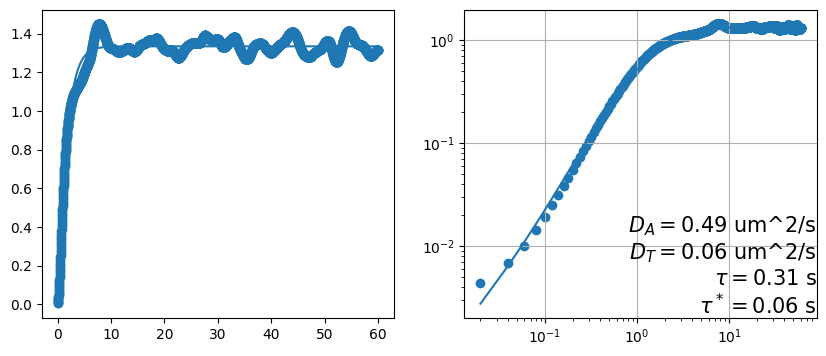

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(x, y)
ax[0].plot(x, memory_model(x, *popt))
ax[1].scatter(x, y)
ax[1].plot(x, memory_model(x, *popt))
ax[1].annotate("$D_A=${0:.2f} um^2/s\n$D_T=${1:.2f} um^2/s\n$\\tau=${2:.2f} s\n$\\tau^*=${1:.2f} s".format(popt[0], popt[1], popt[2], popt[3]), 
               [1, 0], horizontalalignment="right", verticalalignment="bottom", xycoords="axes fraction",
               fontsize=15)
ax[1].loglog()
ax[1].grid()

### Reduced memory model

Remove the thermal term.
$$
\left< \Delta y^2 \right>  = 2 D_A \tau^* \frac{ 1 - e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1 - (\tau/\tau^*)^2}
$$

#### Fit original

In [105]:
def reduced_memory_model(x, DA, tau, tau_star):
    dy2 = 2 * DA * tau_star * (1 - np.exp(-x/tau_star) - tau/tau_star*(1-np.exp(-x/tau))) / (1 - (tau/tau_star)**2)
    return dy2

In [106]:
x = msd.lagt
y = msd["<y^2>"]
popt, pcov = curve_fit(reduced_memory_model, x, y, p0=[1, .1, 2])

In [107]:
popt

array([0.42288315, 0.11427562, 1.68781156])

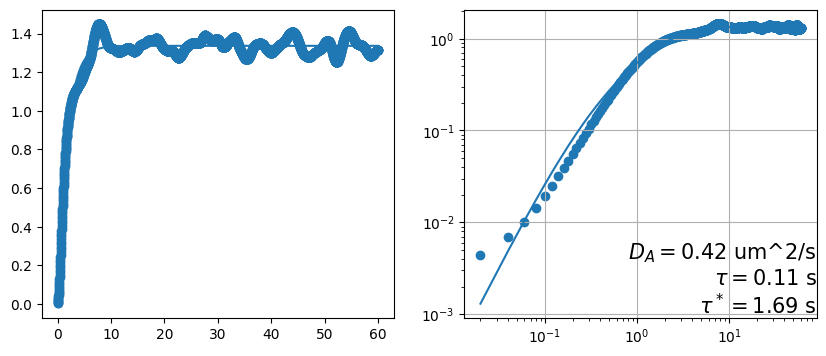

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(x, y)
ax[0].plot(x, reduced_memory_model(x, *popt))
ax[1].scatter(x, y)
ax[1].plot(x, reduced_memory_model(x, *popt))
ax[1].annotate("$D_A=${0:.2f} um^2/s\n$\\tau=${1:.2f} s\n$\\tau^*=${2:.2f} s".format(popt[0], popt[1], popt[2]), 
               [1, 0], horizontalalignment="right", verticalalignment="bottom", xycoords="axes fraction",
               fontsize=15)
ax[1].loglog()
ax[1].grid()

#### Fit log

In [56]:
def reduced_memory_model_log(x, DA, tau, tau_star):
    dy2 = 2 * DA * tau_star * (1 - np.exp(-x/tau_star) - tau/tau_star*(1-np.exp(-x/tau))) / (1 - (tau/tau_star)**2)
    return np.log(dy2)

In [102]:
x = msd.lagt
y = msd["<y^2>"]
popt, pcov = curve_fit(reduced_memory_model_log, x, np.log(y), p0=[1, .1, 2])

C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [103]:
popt

array([0.43202584, 0.1436135 , 1.67917938])

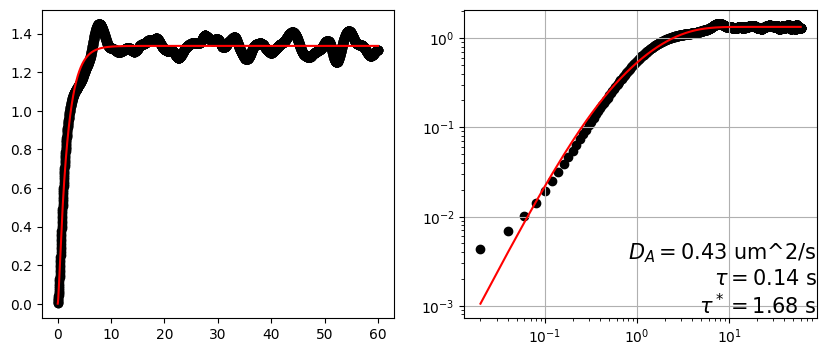

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(x, y, color="black")
ax[0].plot(x, reduced_memory_model(x, *popt), color="red")
ax[1].scatter(x, y, color="black")
ax[1].plot(x, reduced_memory_model(x, *popt), color="red")
ax[1].annotate("$D_A=${0:.2f} um^2/s\n$\\tau=${1:.2f} s\n$\\tau^*=${2:.2f} s".format(popt[0], popt[1], popt[2]), 
               [1, 0], horizontalalignment="right", verticalalignment="bottom", xycoords="axes fraction",
               fontsize=15)
ax[1].loglog()
ax[1].grid()

### Offset reduced memory model

$$
\left< \Delta y^2 \right>  = 2 D_A \tau^* \frac{ 1 - e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1 - (\tau/\tau^*)^2} + c
$$

In [68]:
def offset_reduced_memory_model(x, DA, tau, tau_star, offset):
    dy2 = 2 * DA * tau_star * (1 - np.exp(-x/tau_star) - tau/tau_star*(1-np.exp(-x/tau))) / (1 - (tau/tau_star)**2) + offset
    return dy2

In [61]:
def offset_reduced_memory_model_log(x, DA, tau, tau_star, offset):
    dy2 = 2 * DA * tau_star * (1 - np.exp(-x/tau_star) - tau/tau_star*(1-np.exp(-x/tau))) / (1 - (tau/tau_star)**2) + offset
    return np.log(dy2)

In [197]:
x = msd.lagt
y = msd["<y^2>"]
popt, pcov = curve_fit(offset_reduced_memory_model_log, x, np.log(y), p0=[.11, .01, 2, 0.01])

In [198]:
popt

array([0.517273  , 0.24002375, 1.49333139, 0.00371835])

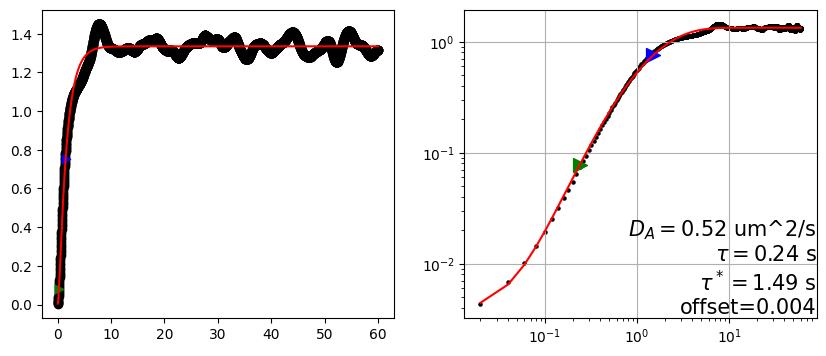

In [199]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(x, y, color="black")
ax[0].plot(x, offset_reduced_memory_model(x, *popt), color="red")
ax[0].scatter(popt[1], offset_reduced_memory_model(popt[1], *popt), color="green", marker=">")
ax[0].scatter(popt[2], offset_reduced_memory_model(popt[2], *popt), color="blue", marker=">")

ax[1].scatter(x, y, color="black", s=5)
ax[1].plot(x, offset_reduced_memory_model(x, *popt), color="red")
ax[1].scatter(popt[1], offset_reduced_memory_model(popt[1], *popt), color="green", marker=">", s=100)
ax[1].scatter(popt[2], offset_reduced_memory_model(popt[2], *popt), color="blue", marker=">", s=100)
ax[1].annotate("$D_A=${0:.2f} um^2/s\n$\\tau=${1:.2f} s\n$\\tau^*=${2:.2f} s\noffset={3:.3f}".format(popt[0], popt[1], popt[2], popt[3]), 
               [1, 0], horizontalalignment="right", verticalalignment="bottom", xycoords="axes fraction",
               fontsize=15)
ax[1].loglog()
ax[1].grid()

### Compute fitting error

We want to have a single number metric to assess the goodness of fit for each method, so we can compare different methods. As a first try, we use:
$$
E = \frac{1}{n} \sum_i^n \frac{|x_i - x^{fit}_i|}{x_i}
$$
where $x_i$ is the value of of $i$th data, $x_i^{fit}$ is the value of the corresponding fit. This error measures the percentage variation of fitting from data, therefore the large MSD does not overweigh the small ones. 

In [161]:
def fit_error(y, yfit, method="relative"):
    """y and yfit are array-like."""
    E = abs((y - yfit) / y).mean()
    return E

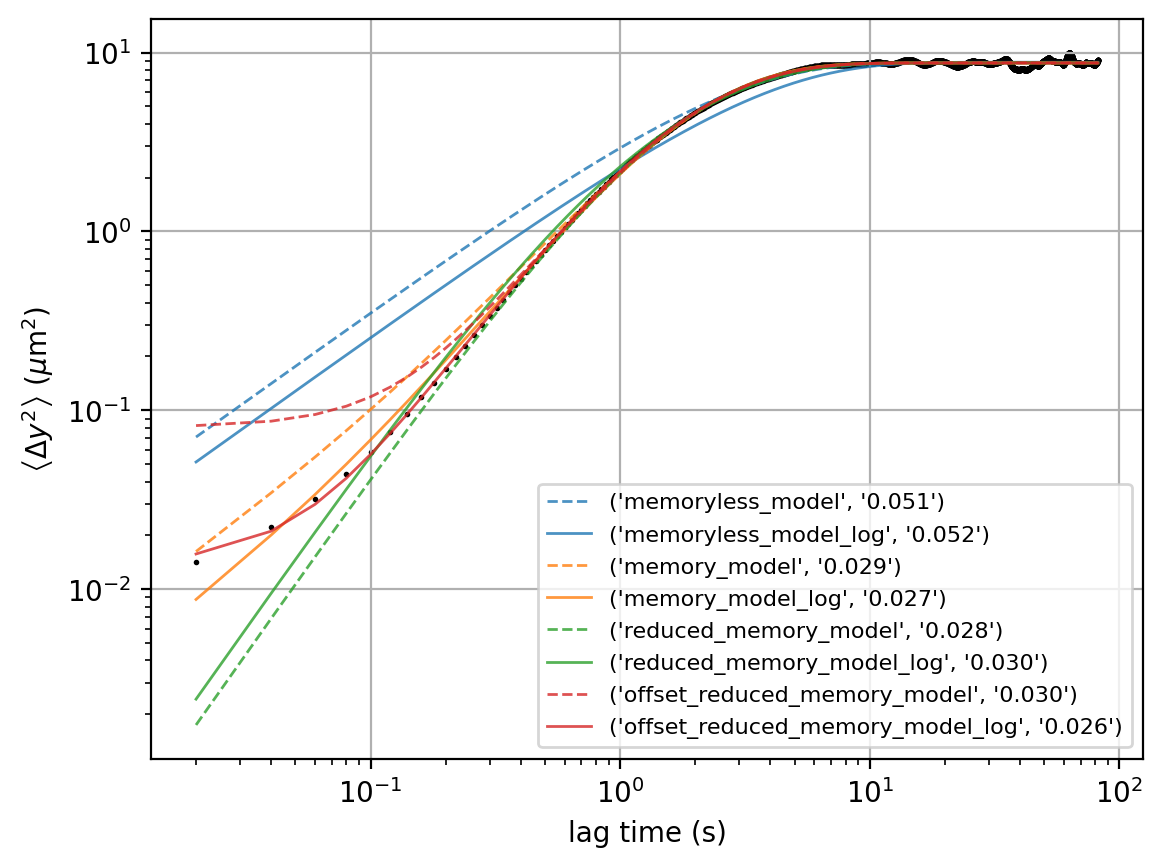

In [257]:
# try all the fittings
models = {"memoryless_model": (memoryless_model, [1, 2], bestcolor(0)), 
          "memoryless_model_log": (memoryless_model_log, [1, 2], bestcolor(0)), 
          "memory_model": (memory_model, [1, 0.01, 0.1, 2], bestcolor(1)), 
          "memory_model_log": (memory_model_log, [1, 0.01, 0.1, 2], bestcolor(1)), 
          "reduced_memory_model": (reduced_memory_model, [1, 0.1, 2], bestcolor(2)), 
          "reduced_memory_model_log": (reduced_memory_model_log, [1, 0.1, 2], bestcolor(2)), 
          "offset_reduced_memory_model": (offset_reduced_memory_model, [1, 0.1, 2, 0.01], bestcolor(3)), 
          "offset_reduced_memory_model_log": (offset_reduced_memory_model_log, [1, 0.1, 2, 0.01], bestcolor(3))}
x = msd.lagt
y = msd["<y^2>"]
fig, ax = plt.subplots(dpi=200)
ax.scatter(x, y, s=1, color="black")
for kw in models:
    model = models[kw][0]
    start_point = models[kw][1]
    color = models[kw][2]
    if kw.endswith("log"):
        popt, pcov = curve_fit(model, x, np.log(y), p0=start_point)
        yfit = np.exp(model(x, *popt))
        ls = "-"
    else:
        popt, pcov = curve_fit(model, x, y, p0=start_point)
        yfit = model(x, *popt)
        ls = "--"
    err = fit_error(y, yfit)
    ax.plot(x, yfit, label=(kw, "{:.3f}".format(err)), color=color, ls=ls, alpha=.8, lw=1)
ax.loglog()
ax.set_xlabel("lag time (s)")
ax.set_ylabel("$\left< \Delta y^2 \\right>$ ($\mu$m$^2$)")
ax.legend(fontsize=8)
ax.grid()
# ax.plot(x, reduced_memory_model(x, 0.372, 0.1652, 3.76/2), color="red")
# ax.plot(x, 0.004+reduced_memory_model(x, 0.372, 0.1652, 3.76/2), color="red", ls="--")

In [135]:
x = msd.lagt
y = msd["<y^2>"]
popt, pcov = curve_fit(memoryless_model, x, y)
yfit = memoryless_model(x, *popt)
fit_error(y, yfit)

0.037850768232305494

In [206]:
yfit = reduced_memory_model(x, 0.372, 0.1652, 3.76/2) + 0.004
fit_error(y, yfit)

0.042120066512684386

### Cristian's model

$$
\left< \Delta y^2 \right> = \frac{2D_A/t_1}{}
$$

In [248]:
def cristian_model(x, DA, t1, t2, c):
    g = 1 / t2
    dy2 = ((2*(DA/t1))/(g+1/t1))*((1-np.exp(-2*g*x))/(2*g)-(np.exp(-x*(g+1/t1))-np.exp(-2*g*x))/(g-1/t1))+c
    return np.log(dy2)

In [249]:
popt, pcov = curve_fit(cristian_model, x, np.log(y), p0=[2, 0.1, 4, 0.001])

In [250]:
popt

array([2.55793023, 0.54890879, 3.89625494, 0.0139091 ])

0.026403273697185536

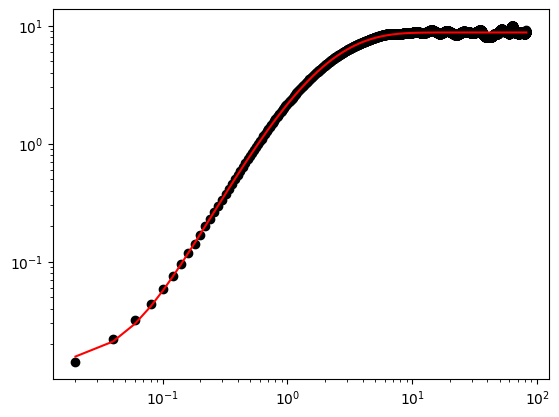

In [255]:
plt.scatter(x, y, color="black")
yfit = np.exp(cristian_model(x, *popt))
plt.plot(x, yfit, color="red")
plt.loglog()
fit_error(y, yfit)